# C3 Project 2: Deep Learning / BoW

⚠️**DISCLAIMER**⚠️ For this project, all the experiments have been done on python scripts uploaded on the project github.

- `main.py`: Contains the main train and test functions.

- `metrics.py`: Defines the BaseMetricsComputer class from which inherit the TestMetrics, TrainMetrics and FoldMetrics. These classes provide the necessary functions for metrics computation.

- `models.py`: Define the SimpleModel (MLP) and the SimpleCNN models.

- `run_experiment_cross_val.py`: Serves as the primary entry point for single cross-validation experiments. It reads configurations  and splits the train set in K-Folds to train the model with 4 folds and then validate it with the remaining fold. This process is repeated K times. Finally, it logs all generated metrics and graphics to Weights & Biases (WandB).

- `run_experiment_test.py`: It follows the same logic as the previous script, but trains the model on the full training set and evaluates its performance on the test set.

- `svm_utils.py`: Contains the functions that allows to train a SVM with the features extracted by the MLP. 

- `sweep_launcher.py`: Configures and initiates WandB Sweeps. It defines grid search configurations for testing different detectors, codebook sizes, and encoding types.

In [110]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

### Ploting functions

In [111]:
def plot_accuracy_boxplots(data, title="Spatial Pyramid Matching Performance", 
                           x_text="", x_axis_label = 'Pyramid Level ($L$)', 
                           y_axis_label = 'Accuracy (%)', 
                           y_dim = [25, 45], bp_width=0.3):
    
    # 1. Extracción de datos
    data_content = data['Data']
    raw_keys = list(data_content['Accuracy'].keys())
    accuracy_data = [data_content['Accuracy'][k] for k in raw_keys]
    levels_numeric = list(range(len(raw_keys)))
    
    # 2. Configuración del gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    color_acc = '#1f77b4' # Azul profesional
    
    # Dibujar Boxplots
    bp = ax.boxplot(accuracy_data, 
                    positions=levels_numeric, 
                    widths=bp_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    medianprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # --- Formateo de Ejes (Aumento de tamaño solicitado) ---
    ax.set_xlabel(x_axis_label, fontsize=16, labelpad=10)
    ax.set_ylabel(y_axis_label, fontsize=16, labelpad=10)
    
    # Aumentamos el tamaño de los números en los ejes (ticks)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Límites del eje Y
    ax.set_ylim(y_dim[0], y_dim[1])
    
    # Etiquetas del eje X
    ax.set_xticks(levels_numeric)
    x_labels = [f"{x_text}{l}" for l in raw_keys]
    ax.set_xticklabels(x_labels) 
    
    # --- Título y Estilo ---
    ax.set_title(title, fontsize=18, fontweight='bold', pad=15)
    
    # Rejilla y estética
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [112]:
def plot_spatial_pyramids_boxplots(data, title="Spatial Pyramid Matching Performance", 
                                x_text="Level", x_axis_label = 'Pyramid Level ($L$)', 
                                y_axis_label_1 = 'Accuracy (%)', y_axis_label_2='Run Time (minutes)', 
                                y1_dim = [25, 45], bp_width=0.3, y2_dim = [0, 10]):

    
    # 1. Data Extraction (ADAPTED for Fisher Vectors/N components)
    data_content = data['Data']
    
    # Get the raw keys (e.g., 'K-Means', 5, 10, 25, 40)
    raw_keys = list(data_content['Accuracy'].keys())
    
    # Extract Accuracy values (lists of results for each key)
    accuracy_data = [data_content['Accuracy'][k] for k in raw_keys]
    
    # Extract Runtime values. Values are assumed to be scalars for each key.
    runtimes = [data_content['Runtime'][k] for k in raw_keys]

    # Create numerical positions (0, 1, 2, ...) for the X-axis
    levels_numeric = list(range(len(raw_keys)))
    
    # 2. Setup Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # --- LEFT Y-AXIS: ACCURACY (BOXPLOTS) ---
    color_acc = '#1f77b4' # Professional Blue
    
    # Draw Boxplots. Use numerical positions for correct placement.
    bp = ax1.boxplot(accuracy_data, 
                     positions=levels_numeric, 
                     widths=bp_width,
                     patch_artist=True, # Allows filling the boxes with color
                     boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                     capprops=dict(color='black'),
                     whiskerprops=dict(color='black'),
                     medianprops=dict(color='black', linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # Axis Formatting
    ax1.set_xlabel(x_axis_label, fontsize=14, labelpad=10)
    ax1.set_ylabel(y_axis_label_1, fontsize=14, color=color_acc, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color_acc)
    
    # Set the specific limits you requested
    ax1.set_ylim(y1_dim[0], y1_dim[1])
    
    # Set X-axis tick positions to the numerical indices
    ax1.set_xticks(levels_numeric)
    
    # Create customized X-axis labels: 'K-Means' is direct, numbers are prefixed by x_text (e.g., 'N 5')
    x_labels = [f"{x_text}{l}" for l in raw_keys]
    ax1.set_xticklabels(x_labels) 
    
    # --- RIGHT Y-AXIS: RUNTIME (LINE) ---
    # Create a second axes object that shares the same x-axis (twinx)
    ax2 = ax1.twinx()
    color_time = '#d62728' # Professional Red
    
    # Plot Time Line. Use numerical positions for correct alignment.
    line2, = ax2.plot(levels_numeric, runtimes, marker='s', linestyle='--', 
                      linewidth=2, color=color_time, label='Run Time')
    
    # Axis Formatting for Time
    ax2.set_ylabel(y_axis_label_2, fontsize=14, color=color_time, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color_time)
    
    # Adjust the upper limit for the runtime axis dynamically
    ax2.set_ylim(y2_dim[0], y2_dim[1])
    
    # --- LEGEND & STYLING ---
    # Create a custom proxy artist for the boxplot to show in the legend
    patch_acc = mpatches.Patch(color=color_acc, label='Accuracy Distribution')
    
    # Combine the legends for both plots (boxplot proxy and line plot)
    lines = [patch_acc, line2]
    labels = [l.get_label() for l in lines]
    
    ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Clean up appearance
    ax1.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax1.spines['top'].set_visible(False) # Hide the top spine for a cleaner look
    
    plt.tight_layout()
    plt.show()

In [113]:
def plot_performance_boxplots(data, title="Comparison of local descriptors (cross-validation)", dim = [10,40], x_axis_title="Descriptors"):
    """
    Generates a grouped boxplot chart to compare performance metrics of different 
    local descriptors across multiple folds.

    Args:
        data (dict): Dictionary where keys are the descriptor names.
                     Values are lists of lists:
                     [ [acc_fold1, acc_fold2...], [f1_fold1...], [prec...], [rec...] ]
                     The order must be: Accuracy, F1, Precision, Recall.
        title (str): Title of the chart.
    """
    
    # 1. Data and Label Preparation
    metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
    descriptors = list(data.keys())
    metrics_colors = ['gold', 'salmon', 'skyblue', 'lightgreen']
    
    # 2. Chart Configuration
    n_descriptors = len(descriptors)
    n_metrics = len(metrics_names)
    
    # Width of individual box
    box_width = 0.15
    # Base positions for groups
    index = np.arange(n_descriptors)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 3. Draw the Grouped Boxplots
    # We iterate by metric to plot all descriptors for that metric at once.
    # This makes handling positions easier.
    
    for i in range(n_metrics):
        # Extract the data for this specific metric across all descriptors
        # metric_data will be a list of lists (one list of folds per descriptor)
        metric_data = [data[desc][i] for desc in descriptors]
        
        # Calculate positions: center around the descriptor index
        positions = index + (i - (n_metrics / 2) + 0.5) * 0.2
        
        # Create the boxplot
        bp = ax.boxplot(metric_data, 
                        positions=positions, 
                        widths=box_width, 
                        patch_artist=True,
                        showfliers=True, # Show outliers
                        boxprops=dict(facecolor=metrics_colors[i], color='black', alpha=0.9),
                        capprops=dict(color='black'),
                        whiskerprops=dict(color='black'),
                        medianprops=dict(color='black', linewidth=1.5),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=3))

    # 4. Customize Axes and Title
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_ylabel('Score (%)', fontsize=16)
    
    # Adjust Y-limits to fit data + margin (e.g., 0 to 50 or dynamic)
    # You might want to change this to ax.set_ylim(0, 100) if scores are high
    ax.set_ylim(dim[0], dim[1]) 
    
    # X-axis formatting
    ax.set_xticks(index)
    ax.set_xticklabels(descriptors, fontsize=16)
    ax.set_xlabel(x_axis_title, fontsize=16)
    
    # 5. Custom Legend
    # Since boxplots don't add labels to legend automatically in a loop well,
    # we create manual proxy artists.
    legend_patches = []
    for i, name in enumerate(metrics_names):
        patch = mpatches.Patch(color=metrics_colors[i], label=name)
        legend_patches.append(patch)
        
    ax.legend(handles=legend_patches, title="Metrics", loc='upper left', fontsize=14, title_fontsize=14)
    
    # Grid and Spines
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.show()

## Image size experiment

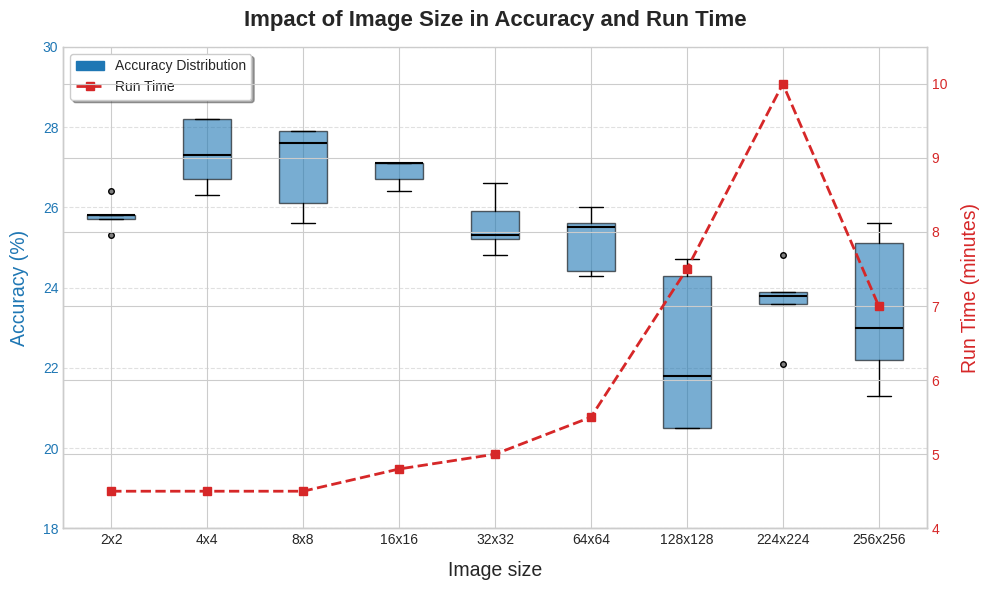

In [114]:
performance_image_size = {
    'Data':{
        'Accuracy':{
            '2x2': [25.7, 25.8, 25.3, 25.8, 26.4],
            '4x4': [26.7, 26.3, 28.2, 28.2, 27.3],
            '8x8': [27.9, 26.1, 27.9, 25.6, 27.6],
            '16x16': [26.7, 26.4, 27.1, 27.1, 27.1],
            '32x32':[25.3, 26.6, 25.2, 24.8, 25.9],
            '64x64':[24.4, 26.0, 25.6, 25.5, 24.3],
            '128x128':[24.3, 20.5, 24.7, 20.5, 21.8],
            '224x224':[23.8, 22.1, 23.6, 24.8, 23.9],
            '256x256':[25.6, 22.2, 23.0, 21.3, 25.1],
        },
        'Runtime':{
            '2x2': 4.5,
            '4x4': 4.5,
            '8x8': 4.5, 
            '16x16': 4.8,
            '32x32': 5,
            '64x64': 5.5,
            '128x128': 7.5, 
            '224x224': 10,
            '256x256': 7
        }
    }
}

plot_spatial_pyramids_boxplots(performance_image_size, title="Impact of Image Size in Accuracy and Run Time", 
                               y1_dim=[18,30], y2_dim=[4, 10.5], x_text="", x_axis_label="Image size", bp_width=0.5)

## Hidden layers experiment

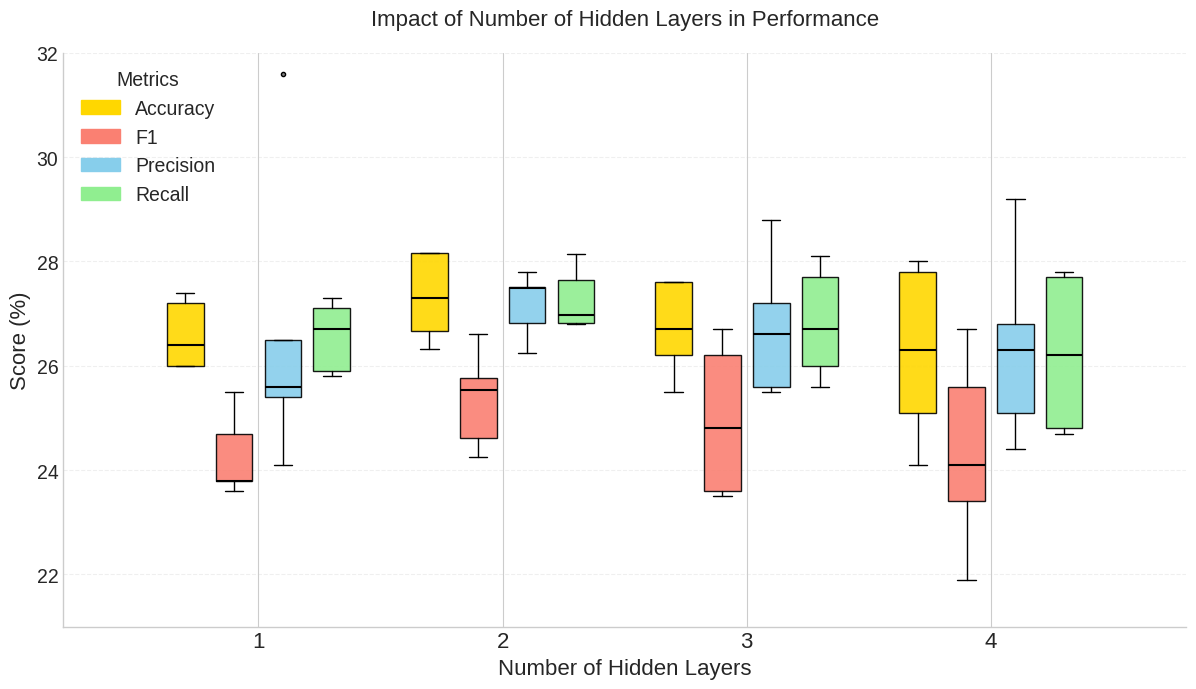

In [115]:
performance_data_folds = {
    '1': [
        [27.2, 26.4, 27.4, 26.0, 26.0],  # Accuracy
        [25.5, 23.8, 24.7, 23.6, 23.8],  # F1
        [26.5, 25.6, 31.6, 25.4, 24.1],  # Precision
        [27.1, 26.7, 27.3, 25.9, 25.8]   # Recall
    ],
    '2': [
        [26.67, 26.32, 28.16, 28.16, 27.30],  # Accuracy
        [24.25, 24.61, 26.60, 25.54, 25.77],  # F1
        [26.24, 27.51, 27.79, 26.82, 27.49],  # Precision
        [26.81, 26.82, 28.14, 27.65, 26.97]   # Recall
    ],
    '3': [
        [26.7, 27.6, 25.5, 27.6, 26.2],  # Accuracy
        [24.8, 26.2, 23.5, 26.7, 23.6],  # F1
        [25.6, 26.6, 25.5, 28.8, 27.2],  # Precision
        [26.7, 28.1, 25.6, 27.7, 26.0]   # Recall
    ],
    '4': [
        [26.3, 24.1, 27.8, 28.0, 25.1],  # Accuracy
        [24.1, 21.9, 25.6, 26.7, 23.4],  # F1
        [25.1, 24.4, 26.3, 26.8, 29.2],  # Precision
        [26.2, 24.8, 27.7, 27.8, 24.7]   # Recall
    ],
}

plot_performance_boxplots(performance_data_folds, title="Impact of Number of Hidden Layers in Performance", dim=[21,32], x_axis_title="Number of Hidden Layers")

## MLP vs MLP+SVM Experiment

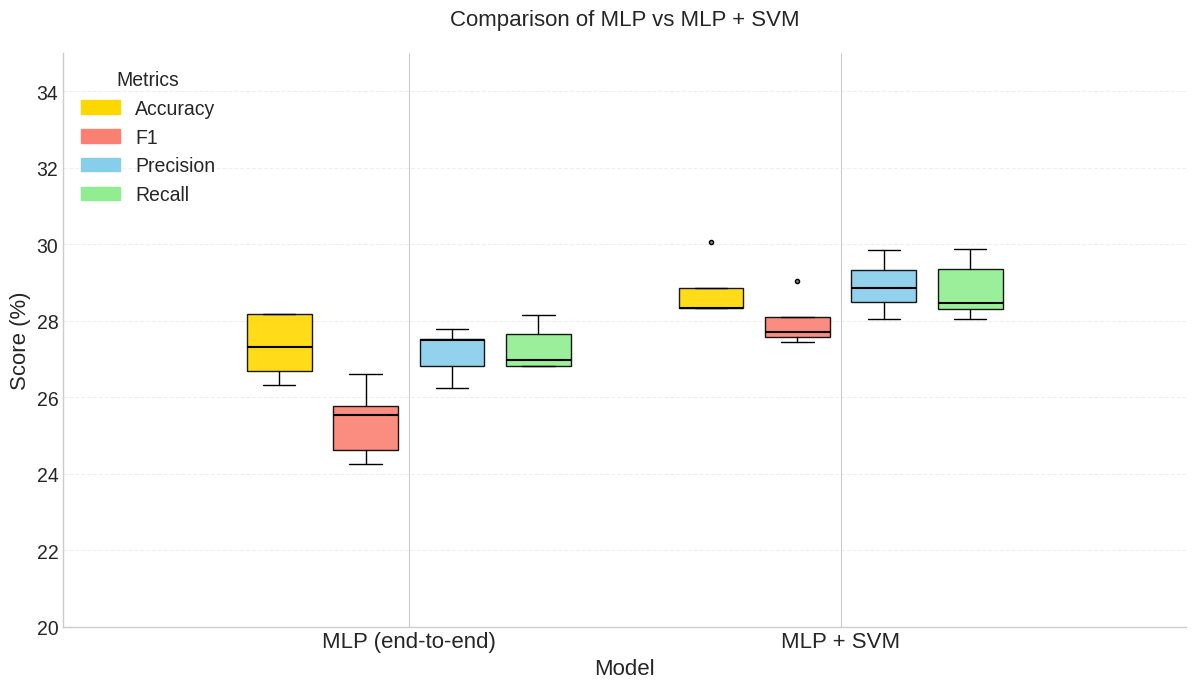

In [116]:
performance_data_folds = {
    'MLP (end-to-end)': [
        [26.67, 26.32, 28.16, 28.16, 27.30],  # Accuracy
        [24.25, 24.61, 26.60, 25.54, 25.77],  # F1
        [26.24, 27.51, 27.79, 26.82, 27.49],  # Precision
        [26.81, 26.82, 28.14, 27.65, 26.97]   # Recall
    ],
    'MLP + SVM': [
        [28.33, 28.85, 28.33, 30.06, 28.33],  # Accuracy
        [27.45, 28.10, 27.69, 29.03, 27.56],  # F1
        [28.04, 29.32, 28.85, 29.84, 28.49],  # Precision
        [28.29, 29.36, 28.46, 29.86, 28.05]   # Recall
    ],
}

plot_performance_boxplots(performance_data_folds, title="Comparison of MLP vs MLP + SVM", dim=[20,35], x_axis_title="Model")

## MLP with Patches + SVM classificator Experiment

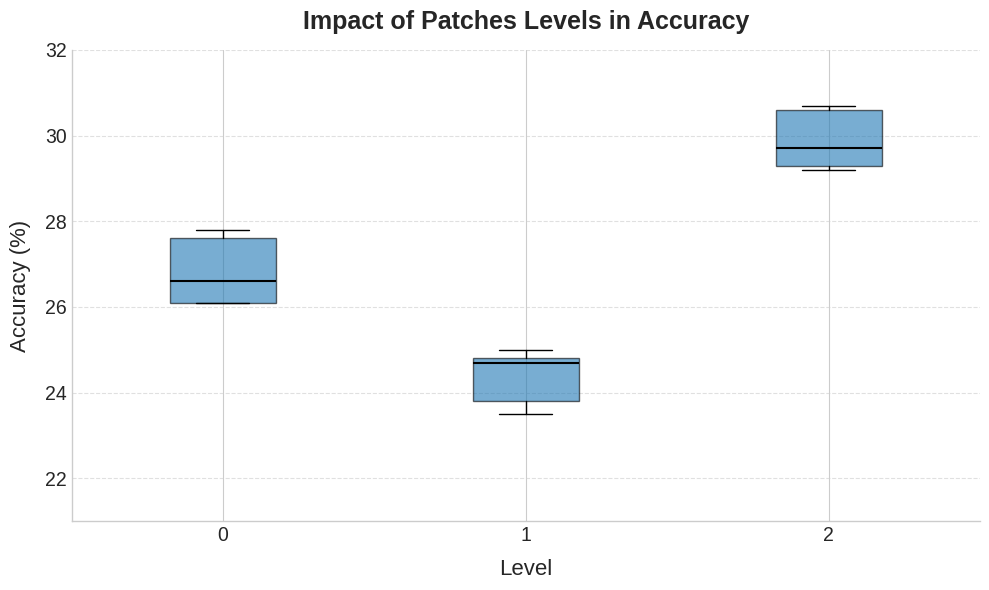

In [134]:
performance_image_size = {
    'Data':{
        'Accuracy':{
            '0': [27.6, 26.6, 27.8, 26.1, 26.1],
            '1': [23.5, 24.7, 25.0, 23.8, 24.8],
            '2': [29.3, 29.2, 29.7, 30.7, 30.6]
        }
    }
}

plot_accuracy_boxplots(performance_image_size, title="Impact of Patches Levels in Accuracy", 
                               y_dim=[21, 32], x_text="", x_axis_label="Level", bp_width=0.35)

## MLP with Patches + Fisher vectors + SVM classificator Experiment

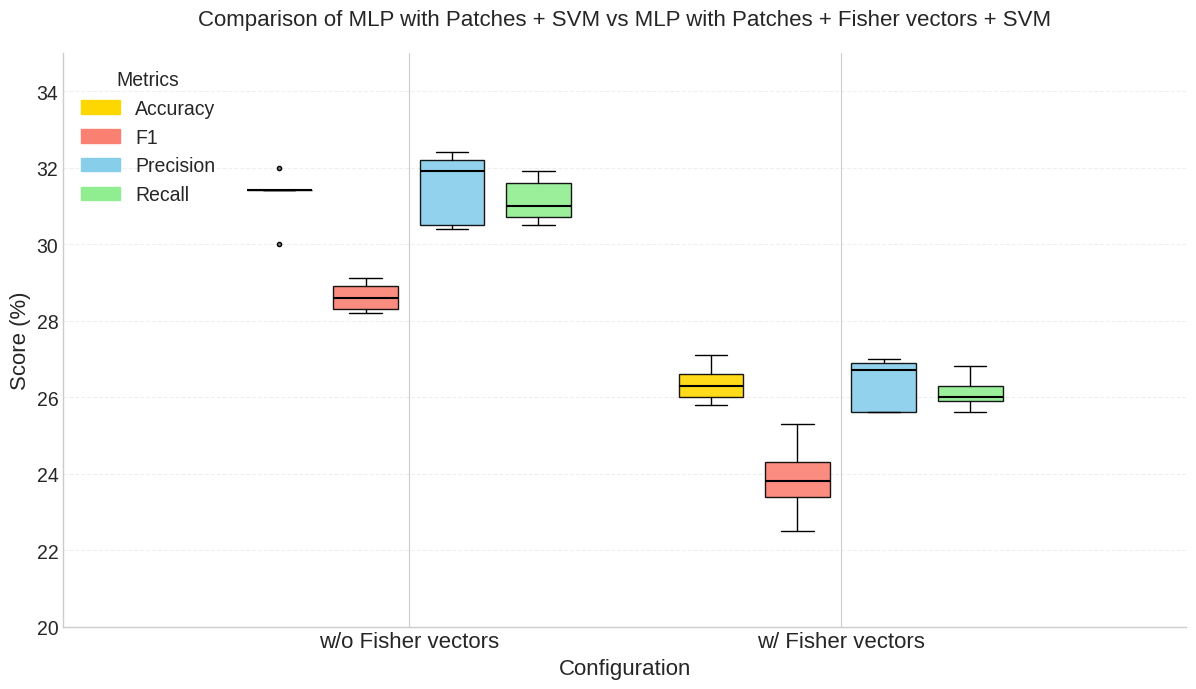

In [ ]:
performance_data_folds = {
    'w/o Fisher vectors': [
        [31.4, 30.0, 31.4, 32.0, 30.9],
        [28.9, 29.1, 28.6, 28.2, 28.3],
        [32.4, 32.2, 30.4, 30.5, 31.9],
        [31.9, 31.0, 30.5, 31.6, 30.7]
    ],
    'w/ Fisher vectors': [
        [25.8, 26.0, 27.1, 26.6, 26.3],
        [24.3, 23.4, 25.3, 23.8, 22.5],
        [25.6, 26.9, 27.0, 25.6, 26.7],
        [26.0, 25.9, 26.8, 26.3, 25.6]
    ],
}

plot_performance_boxplots(performance_data_folds, title="Comparison of MLP with Patches + SVM vs MLP with Patches + Fisher vectors + SVM", dim=[20,35], x_axis_title="Configuration")
